In [1]:
import sys
import datacube
import numpy as np
import seaborn as sns
import xarray as xr
import pandas as pd
from datacube.utils import geometry
from datacube.utils.geometry import CRS

# Import external functions from dea-notebooks using relative link to Scripts
sys.path.append('../10_Scripts')
import DEADataHandling
import DEAPlotting
import os
import SpatialTools
import gdal

# Connect to datacube database
dc = datacube.Datacube(app='Snow monitoring with Landsat')


In [2]:
# lat, lon, buffer_m, buffer_n = -36.86895, 147.276, 30000, 30000 #vic
# lat, lon, buffer_m, buffer_n = -41.56728, 147.67106, 10000, 10000 #tas ben lomond
# lat, lon, buffer_m = -36.435, 148.29, 35000, 45000 #nsw
time_range = ('2017-01-01', '2017-01-31')
resolution = (-25, 25)
landsat_goodquality_prop = 0.10
ndsi_threshold = 0.2
ndvi_threshold = 0.3
ndwi_threshold = 0.15


In [5]:
# lat, lon, buffer_m, buffer_n = -36.3, 148.35, 35000, 45000 #nsw
# lat, lon, buffer_m, buffer_n = -36.86895, 147.276, 30000, 30000 #vic

# lat, lon, buffer_m, buffer_n = -68.56, 78.253, 30000, 20000 #vestfold hills

lat, lon, buffer_m, buffer_n = -41.983, 146.305, 30000, 20000 #mt ossa

# Set range of time to return data from both Landsat and Sentinel 2
time_range = ('2018-01-01', '2018-03-31')
elev=1200
resolution = (-25, 25)

landsat_goodquality_prop = 0.3

ndsi_threshold = 0.2
ndvi_threshold = 0.3
ndwi_threshold = 0.15

x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer_m, x + buffer_m),
         'y': (y - buffer_n, y + buffer_n),    
         'time': time_range,
         'crs': 'EPSG:3577',
         'output_crs': 'EPSG:3577',
         'resolution': resolution} 

print('loading landsat_ds')
snow_mask = dict(cloud_acca='no_cloud',
                 #cloud_fmask='no_cloud',
                 cloud_shadow_acca='no_cloud_shadow',
                 #cloud_shadow_fmask='no_cloud_shadow',
                 blue_saturated=False,
                 green_saturated=False,
                 red_saturated=False,
                 nir_saturated=False,
                 swir1_saturated=False,
                 swir2_saturated=False,
                 contiguous=True)

landsat_ds = DEADataHandling.load_clearlandsat(dc=dc, 
                                               product = 'nbar',
                                               query=query,
                                               mask_dict=snow_mask,
                                               sensors=['ls8'],
                                               bands_of_interest=['red', 'green', 'blue','nir', 'swir1'],
                                               masked_prop=landsat_goodquality_prop,
                                               mask_pixel_quality=True,
                                               ls7_slc_off=True)

loading landsat_ds
Loading ls8
    Loading 6 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


In [6]:
# Set up analysis data query using a buffer around a lat-long point.
# This converts a lat long to Australian Albers, then creates a square analysis region
# by creating a square buffer around the point.
# x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
# query = {'x': (x - buffer_m, x + buffer_m),
#          'y': (y - buffer_m, y + buffer_m),    
#          'time': time_range,
#          'crs': 'EPSG:3577',
#          'output_crs': 'EPSG:3577',
#          'resolution': resolution} 


x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer_m, x + buffer_m),
         'y': (y - buffer_n, y + buffer_n),    
         'time': time_range,
         'crs': 'EPSG:3577',
         'output_crs': 'EPSG:3577',
         'resolution': resolution} 

#Preview area that data will be loaded for:
DEAPlotting.display_map(y=query['y'], x=query['x'])


In [10]:
landsat_ds = DEADataHandling.load_clearlandsat(dc=dc, 
                                               query=query, 
                                               sensors=['ls8'],
                                               bands_of_interest=['red', 'green', 'nir', 'swir1'],
                                               masked_prop=landsat_goodquality_prop, 
                                               ls7_slc_off=True)

print(landsat_ds)


Loading ls8
    Loading 4 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)
<xarray.Dataset>
Dimensions:    (time: 4, x: 2401, y: 2401)
Coordinates:
  * time       (time) datetime64[ns] 2017-01-06T00:03:15 ... 2017-01-30T23:56:55
  * y          (y) float64 -4.081e+06 -4.081e+06 ... -4.141e+06 -4.141e+06
  * x          (x) float64 1.333e+06 1.333e+06 1.333e+06 ... 1.393e+06 1.393e+06
Data variables:
    red        (time, y, x) float64 357.0 310.0 335.0 281.0 ... nan nan nan nan
    green      (time, y, x) float64 335.0 305.0 308.0 297.0 ... nan nan nan nan
    nir        (time, y, x) float64 2.368e+03 2.278e+03 2.285e+03 ... nan nan
    swir1      (time, y, x) float64 1.055e+03 954.0 945.0 922.0 ... nan nan nan
    data_perc  (time, y, x) float64 0.3484 0.3484 0.3484 0.3484 ... nan nan nan
Attributes:
    crs:      EPSG:3577


In [10]:
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer_m, x + buffer_m),
         'y': (y - buffer_m, y + buffer_m),    
         #'time': time_range,
         'crs': 'EPSG:3577',
         'output_crs': 'EPSG:3577',
         'resolution': resolution}

# Load the DEM data
dem_ds = dc.load(product='srtm_dem1sv1_0', **query)

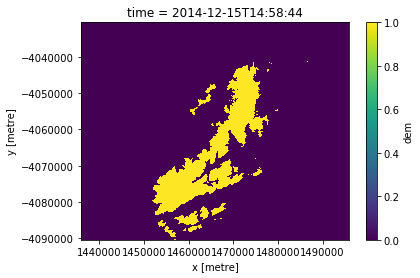

In [16]:
dem_1800 = dem_ds.dem > 1750
dem_1800.plot()

In [8]:
valid_ds = np.isfinite(landsat_ds.swir1)

In [9]:
ndsi_ds = (landsat_ds.green - landsat_ds.swir1) / (landsat_ds.green + landsat_ds.swir1)
ndvi_ds = (landsat_ds.nir - landsat_ds.red) / (landsat_ds.nir + landsat_ds.red)
ndwi_ds = (landsat_ds.green - landsat_ds.nir)/(landsat_ds.green + landsat_ds.nir)

In [9]:
snow_ds = ndsi_ds > ndsi_threshold
noveg_ds = ndvi_ds < ndvi_threshold
nowater_ds = ndwi_ds < ndwi_threshold
snow_ds = noveg_ds & snow_ds & nowater_ds

In [10]:
snow_sum = snow_ds.sum(dim=['x', 'y'])
valid_sum = valid_ds.sum(dim=['x', 'y'])
snow_prop = (snow_sum / valid_sum)
#snow_prop.values

In [11]:
snow_sum_perpixel = snow_ds.sum(dim=['time'])
valid_sum_perpixel = valid_ds.sum(dim=['time'])
snow_prop_perpixel = (snow_sum_perpixel / valid_sum_perpixel)


In [20]:
snow_sum = snow_ds.groupby('time.month').sum()
valid_sum = valid_ds.groupby('time.month').sum()
snow_prop = (snow_sum / valid_sum)

In [1]:
snow_sum_perpixel = snow_ds.sum(dim=['time'])
valid_sum_perpixel = valid_ds.sum(dim=['time'])
snow_prop_perpixel = (snow_sum_perpixel / valid_sum_perpixel)
#snow_sum_perpixel.plot(cmap='Blues', robust=True)

NameError: name 'snow_ds' is not defined

In [ ]:
transform, projection = SpatialTools.geotransform(snow_prop_perpixel, (snow_prop_perpixel.x, snow_prop_perpixel.y), epsg=3577)
SpatialTools.array_to_geotiff('out_snow.tif',
              snow_prop_perpixel.values, geo_transform = transform, 
              projection = projection, 
              nodata_val=np.nan)

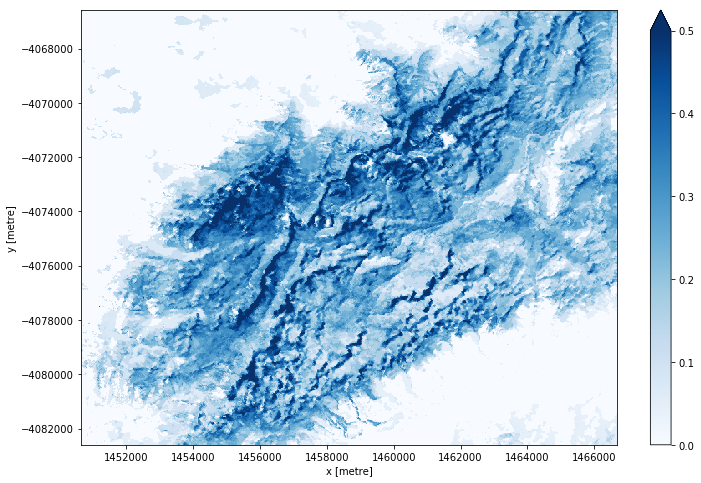

In [23]:
snow_prop_perpixel.plot(cmap='Blues', robust=True, figsize=(12, 8))

In [18]:
#snow_sum.plot()

In [16]:
# a=snow_ds.groupby('time.month').sum(dim=['x','y'])
a=snow_ds.groupby('time.month').sum()
a

<xarray.DataArray (month: 12)>
array([    32,     93,    104,    796, 118840, 174058,  79952, 208908, 107955,
       409589,  52713,   6939])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

AttributeError: 'DataArrayGroupBy' object has no attribute 'plot'

In [ ]:
# snow_prop_perpixel=snow_prop_perpixel.squeeze
#snow_ds = snow_ds.drop('time')

In [130]:
transform, projection = SpatialTools.geotransform(snow_prop_perpixel, (snow_prop_perpixel.x, snow_prop_perpixel.y), epsg=3577)
SpatialTools.array_to_geotiff('out_snow.tif',
              snow_prop_perpixel.values, geo_transform = transform, 
              projection = projection, 
              nodata_val=np.nan)

This function is written for use with the GDAL run 'array_to_geotiff' function and should be used with extreme caution elsewhere.


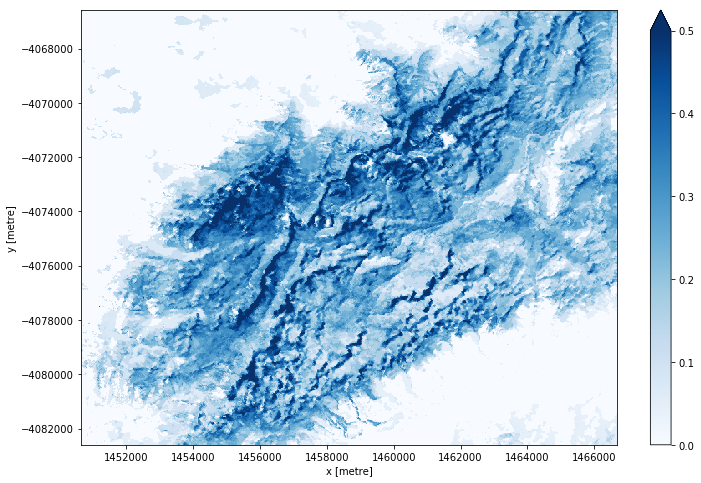

In [127]:
#snow_prop_perpixel.plot(cmap='Blues', robust=True, figsize=(12, 8))

In [103]:
np.count_nonzero(snow_ds.isel(time=1))

1

In [98]:
snow_ds.time[('time.month')]

<xarray.DataArray 'month' (time: 4)>
array([1, 1, 2, 2])
Coordinates:
  * time     (time) datetime64[ns] 2017-01-14T23:57:02 ... 2017-02-15T23:56:48

In [99]:
a=snow_ds.groupby('time.month').sum()

# snow_ds.resample(time='M', keep_attrs=bool)
# snow_ds.time['time.month']a
a

<xarray.DataArray (month: 2)>
array([32, 93])
Coordinates:
  * month    (month) int64 1 2

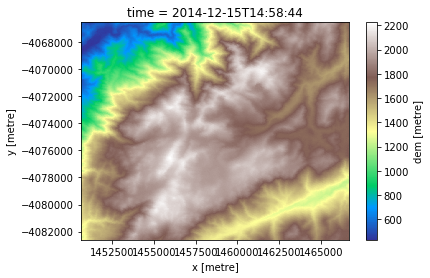

In [13]:

dem_ds = dc.load(product='srtm_dem1sv1_0', **query)

dem_ds.dem.plot(cmap='terrain')

We can return elevation data from the DEM for the area covered by snow in each timestep in our snow dataset:

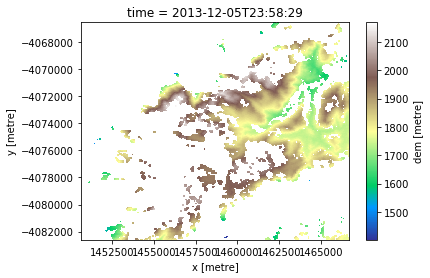

In [15]:
# Clip DEM to snow extent for every timestep
snow_elev_ds = dem_ds.dem.squeeze(dim='time').where(snow_ds)

# Plot example of clipped data for one timestep
snow_elev_ds.isel(time=40).plot(cmap='terrain')

We can plot the median elevation of the snow cover across time. However, this data can be extremely noisy, as it includes the elevation of small snow extents during summer and lower elevation pixels accidently mapped as snow:

In [38]:
snow_elev_ts = snow_elev_ds.median(dim=['x', 'y'])
snow_elev_ts.plot(figsize=(16,6))

NameError: name 'snow_elev_ds' is not defined

A nicer way to visualise the data is using boxplots to summarise snow cover elevation for each year. This lets us compare the entire elevation range covered by snow annually:

Text(0.5, 0.98, 'Annual snow elevation distribution')

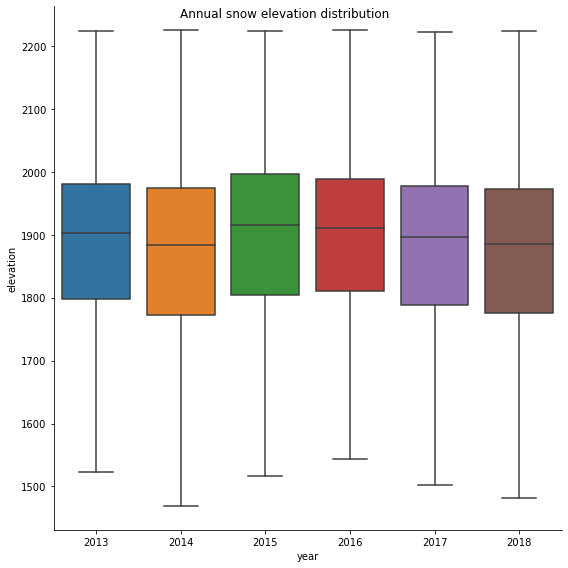

In [28]:
# Convert xarray data into a Pandas dataframe with one row per observation
snow_elev_df = (snow_elev_ds
                .stack(z=('x', 'y'))   # change the data from 4D (time, x, y) to 2D (time, location)
                .to_pandas()           # convert to a dataframe/table format
                .reset_index()         # turn the 'time' index into a normal column
                .melt(id_vars='time',  # rearrange the data to have one observation per row
                      value_name='elevation')
                .dropna()              # remove all empty observations (no snow)
                .sample(1000000))      # take a limited sample of rows to allow faster plotting

# Add a new column to allow summarising data by year
snow_elev_df['year'] = snow_elev_df.time.dt.year

# Plot each year's data as a boxplot to allow us to compare the elevation range
ax = sns.catplot(data=snow_elev_df, x='year', y='elevation', kind='box', showfliers=False, height=8)

# Add a title
ax.fig.suptitle('Annual snow elevation distribution')